<a href="https://colab.research.google.com/github/ChaitraliL/Artificial-Intelligence/blob/master/GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1pWeehYrsT38SRJDSMyPhkEeVK4Yeh_rc'})
download.GetContentFile('train.csv')

In [0]:
load = drive.CreateFile({'id': '1EFx16wpFZBy0XWRIU5soK0SuSvl6chgt'})
load.GetContentFile('test.csv')

In [6]:
!ls

adc.json  sample_data  test.csv  train.csv


In [10]:
!pip3 install deap

    100% |████████████████████████████████| 942kB 17.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/22/ea/bf/dc7c8a2262025a0ab5da9ef02282c198be88902791ca0c6658
Successfully built deap


In [0]:
import pandas as pd
import numpy as np
import random as rnd

#Genetic Algorithm - https://github.com/deap/deap
from deap import base
from deap import creator
from deap import tools

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning models
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
# machine learning auxiliaries
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import make_pipeline

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
dfs = [train_df, test_df]
full_origin = pd.concat([train_df.drop('Survived',1),test_df])

print('Data loaded...')

Data loaded...


In [3]:
def cleanTicket(ticket):
    ori_ticket = ticket
    ticket = ticket.replace( '.' , '' )
    ticket = ticket.replace( '/' , '' )
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'

def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df['AgeBins'] = categories
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df['FareBins'] = categories
    return df

def encode_features(df_train, df_test, features):
    df_combined = pd.concat([df_train[features], df_test[features]])    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

#Creating Title feature and mapping some synonyms
for dataset in dfs:
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

#Converting Sex categorical feature to int value
for dataset in dfs:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

#Checking Age missing values
for dataset in dfs:
    dataset['Age_known'] = dataset['Age'].isnull() == False

#Filling in missing values: Embarked (missing only in train dataset)
train_df['Embarked'].iloc[61] = "C"
train_df['Embarked'].iloc[829] = "C"

#Filling in missing values: Fare (missing only in test dataset)
#using the median value for the 3st class 
all_df = pd.concat([train_df.drop('Survived',1),test_df])
test_df['Fare'].iloc[152] = all_df['Fare'][all_df['Pclass'] == 3].dropna().median()

#Filling in missing values: Age
#Guessing value from similares sex-title and sex-class median values
all_df = pd.concat([train_df.drop('Survived',1),test_df])
titleList = all_df['Title'].unique().tolist()
guess_ages_sex_title = np.zeros((2,len(titleList)))
guess_ages_sex_pclass = np.zeros((2,3))
for dataset in dfs:
    for i in range(0, 2):#Sex
        for j in range(0, 3):#Pclass
            guess_df = all_df[(all_df['Sex'] == i) & (all_df['Pclass'] == j+1)]['Age'].dropna()
            age_guess = guess_df.median()
            guess_ages_sex_pclass[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            for title in titleList:#Title
                k = titleList.index(title)
                guess_df = all_df[(all_df['Title'] == title) & (all_df['Sex'] == i)]['Age'].dropna()
                                
                # age_mean = guess_df.mean()
                # age_std = guess_df.std()
                # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

                age_guess2 = guess_df.median()                
                if (age_guess2!=age_guess2):#if Nan
                    age_guess2 = age_guess
                
                guess_ages_sex_title[i,k] = int( age_guess2/0.5 + 0.5 ) * 0.5
    
    for i in range(0, 2):
        for j in range(0, 3):
            for k in range(0, len(titleList)):
                dataset.loc[ (dataset.Age.isnull()) & (dataset.Title == titleList[k]) & (dataset.Sex == i) ,\
                    'Age'] = guess_ages_sex_title[i,k]
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages_sex_pclass[i,j]

    dataset['Age'] = dataset['Age'].astype(int)
    
#creating Deck and FamilyName features
for dataset in dfs:    
    dataset['Deck'] = dataset['Cabin'].str[0]
    dataset['FamilyName'] = dataset['Name'].str.split(", ", expand=True)[0]
    
all_df = pd.concat([train_df.drop('Survived',1),test_df])
print("Initial missing Deck values: ",len(all_df.loc[all_df['Deck'].isnull()]))

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Initial missing Deck values:  1014


In [4]:
#Guessing Deck missing values from the Ticket value. 
TicketList = all_df['Ticket'].unique().tolist()
for dataset in dfs:    
    for ticket in TicketList:
        guess_deck = all_df[(all_df['Ticket'] == ticket)]['Deck'].dropna()
        if(len(guess_deck.index)>0):
            guess_deck = guess_deck.iloc[0][0]
            dataset.loc[(dataset.Deck.isnull()) & (dataset.Ticket == ticket),'Deck'] = guess_deck
all_df = pd.concat([train_df.drop('Survived',1),test_df])
print("Missing Deck values after apply shared ticket heuristic: ",len(all_df.loc[all_df['Deck'].isnull()]))


Missing Deck values after apply shared ticket heuristic:  998


In [5]:
#Trying to guess Deck missing values using a prediction Model.
all_df = pd.concat([train_df,test_df])
df = all_df[['Pclass','Fare','Embarked','Deck']]
df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)   
df1 = df[df['Deck'].notnull()]
XDeck_train = df1[['Pclass','Fare','Embarked']]
YDeck_train = df1.Deck
random_forest = RandomForestClassifier(n_estimators=100)

scores = cross_val_score(random_forest, XDeck_train, YDeck_train, cv=5, n_jobs=-1)
print("CV score: ",scores.mean())

random_forest.fit(XDeck_train, YDeck_train)
XDeck_test = df[['Pclass','Fare','Embarked']]
YDeck_pred = random_forest.predict(XDeck_test)
all_df['DeckPred'] = YDeck_pred
all_df.loc[(all_df.Deck.isnull()),'Deck'] = all_df.loc[(all_df.Deck.isnull()),'DeckPred']
train_df['Deck'] = all_df[ 0:891 ]['Deck']
test_df['Deck'] = all_df[ 891: ]['Deck']
               
all_df = pd.concat([train_df.drop('Survived',1),test_df])
print("Missing Deck values: ",len(all_df.loc[all_df['Deck'].isnull()]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


CV score:  0.6955128029888827
Missing Deck values:  0


Survived,0,1
NameContainsP,,
False,516,232
True,33,110


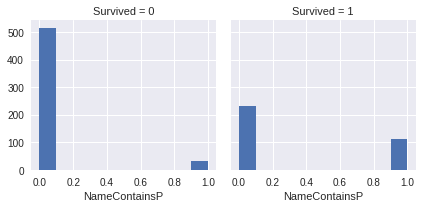

In [6]:
#Creating feature NameContainsP
for dataset in dfs:    
    dataset["NameContainsP"] = dataset["Name"].apply(lambda x: "(" in x) #If the name contain "("

g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'NameContainsP')

pd.crosstab(train_df['NameContainsP'], train_df['Survived'])

In [7]:
#creating some new features
all_df = pd.concat([train_df.drop('Survived',1),test_df])
for dataset in dfs:    
    simplify_fares(dataset)#ranges of fares
    simplify_ages(dataset)#ranges of ages
    dataset['Child'] = dataset['Age']<=10
    dataset['MedianAge'] = (dataset['Age']>=18) & (dataset['Age']<=40)
    dataset['Young_m'] = (dataset['Age']>=18) & (dataset['Age']<=40) & (dataset['Sex']==0)
    dataset['Young_f'] = (dataset['Age']>=18) & (dataset['Age']<=40) & (dataset['Sex']==1)
    dataset['Family'] = dataset['SibSp'] + dataset['Parch']
    dataset['Alone']  = (dataset['SibSp'] + dataset['Parch']) == 0
    dataset['Cabin_known'] = dataset['Cabin'].isnull() == False
    dataset["Cabin_known"] = dataset["Cabin_known"].astype("int")    
    dataset['Ttype'] = dataset['Ticket'].str[0]
    dataset['Ttype2'] = dataset['Ticket'].map(cleanTicket)    
    dataset['Bad_ticket'] = dataset['Ttype'].isin(['3','4','5','6','7','8','A','L','W'])
    dataset["NameLength"] = dataset["Name"].apply(lambda x: len(x))  #Create feture for name length         
    dataset['Ticket_group'] = dataset.groupby('Ticket')['Name'].transform('count')
    dataset['Fare_eff'] = dataset['Fare']/dataset['Ticket_group']
    dataset['Shared_ticket'] = 3
    for i in range(len(dataset)):
        if dataset['Shared_ticket'].iloc[i]==3:            
            if ((len(all_df.groupby('Ticket').get_group(dataset['Ticket'].iloc[i]))) > 1 ):
                dataset.loc[dataset['Ticket'] == dataset['Ticket'].iloc[i], 'Shared_ticket'] = 1
            else:
                dataset.loc[dataset['Ticket'] == dataset['Ticket'].iloc[i], 'Shared_ticket'] = 0
    
    dataset['Young'] = (dataset['Age']<=20) | (dataset['Title'].isin(['Master','Miss','Mlle','Mme']))
     #FareBand
    dataset['FareBand'] = 0
    dataset.loc[ dataset['Fare'] <= 7.91, 'FareBand'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'FareBand'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'FareBand']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'FareBand'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    #AgeBand
    dataset['AgeBand'] = 0
    dataset.loc[ dataset['Age'] <= 16, 'AgeBand'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'AgeBand'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'AgeBand'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'AgeBand'] = 3
    dataset.loc[ dataset['Age'] > 64, 'AgeBand'] = 4    
    
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }

#Converting categorical features to integer values
for dataset in dfs:      
    #Title
    # we map each title
    dataset[ 'Title' ] = dataset.Title.map( Title_Dictionary )
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Officer": 5, "Royalty": 6}    
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    dataset['Title'] = dataset['Title'].astype(int)    
    dataset['Ttype'] = dataset['Ttype'].map( {'1': 1, '2': 2, '3': 3, '4': 4,'5': 5,'6': 6, '7': 7, '8': 8,'9': 9,'A': 10, 'C': 11, 'F': 12,'L': 13, 'P': 14, 'S': 15,'W': 16} ).astype(int)    
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)    
    dataset['Deck'] = dataset['Deck'].map( {'U': 0, 'C': 1, 'E': 2,'G': 3, 'D': 4, 'A': 5,'B': 6, 'F': 7, 'T': 8} ).astype(int)    
    for col in dataset.columns:
        if(dataset[col].dtype == 'bool'):
            dataset[col] = dataset[col].astype(int)

print("Ok. Data are now almost preprocessed...")

Ok. Data are now almost preprocessed...


In [8]:
# preview the final data
all_df = pd.concat([train_df.drop('Survived',1),test_df])
print(all_df.info())
all_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 35 columns):
PassengerId      1309 non-null int64
Pclass           1309 non-null int64
Name             1309 non-null object
Sex              1309 non-null int64
Age              1309 non-null int64
SibSp            1309 non-null int64
Parch            1309 non-null int64
Ticket           1309 non-null object
Fare             1309 non-null int64
Cabin            295 non-null object
Embarked         1309 non-null int64
Title            1309 non-null int64
Age_known        1309 non-null int64
Deck             1309 non-null int64
FamilyName       1309 non-null object
NameContainsP    1309 non-null int64
FareBins         1309 non-null category
AgeBins          1309 non-null category
Child            1309 non-null int64
MedianAge        1309 non-null int64
Young_m          1309 non-null int64
Young_f          1309 non-null int64
Family           1309 non-null int64
Alone            1309 non-null int

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Ttype,Ttype2,Bad_ticket,NameLength,Ticket_group,Fare_eff,Shared_ticket,Young,FareBand,AgeBand
0,1,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7,NaN,...,10,A5,1,23,1,7.2500,0,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71,C85,...,14,PC,0,51,1,71.2833,1,0,3,2
2,3,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7,NaN,...,15,STONO2,0,22,1,7.9250,0,1,1,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53,C123,...,1,XXX,0,44,2,26.5500,1,0,3,2
4,5,3,"Allen, Mr. William Henry",0,35,0,0,373450,8,NaN,...,3,XXX,1,24,1,8.0500,0,0,1,2


In [9]:
#Encoding to Numeric values
train_df, test_df = encode_features(train_df, test_df, ['FamilyName','AgeBins','FareBins','Ttype2'])
#preparing dataset
selCols = []
#filtering only numeric attributes
for col in test_df.columns:
    if(test_df[col].dtype == 'int64' or test_df[col].dtype == 'float64' or test_df[col].dtype == 'uint8'):
        selCols.append(col)        

#removing some supposed helpless attributes
#if 'SibSp' in selCols: selCols.remove('SibSp')
#if 'Parch' in selCols: selCols.remove('Parch')
#if 'AgeBand' in selCols: selCols.remove('AgeBand')
#if 'FareBand' in selCols: selCols.remove('FareBand')
if 'PassengerId' in selCols: selCols.remove('PassengerId')
if 'Survived' in selCols: selCols.remove('Survived')

train_df = train_df.loc[:,selCols+['Survived']]
test_df = test_df.loc[:,selCols+['PassengerId']]
train_df.head()

print("Number of selected cols ",len(selCols)," :",selCols)
print()
all_df = pd.concat([train_df,test_df])
print(all_df.describe())

Number of selected cols  31  : ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'Age_known', 'Deck', 'FamilyName', 'NameContainsP', 'FareBins', 'AgeBins', 'Child', 'MedianAge', 'Young_m', 'Young_f', 'Family', 'Alone', 'Cabin_known', 'Ttype', 'Ttype2', 'Bad_ticket', 'NameLength', 'Ticket_group', 'Fare_eff', 'Shared_ticket', 'Young', 'FareBand', 'AgeBand']

               Age      AgeBand      AgeBins    Age_known        Alone  \
count  1309.000000  1309.000000  1309.000000  1309.000000  1309.000000   
mean     29.397250     1.307105     4.114591     0.799083     0.603514   
std      13.169718     0.807336     2.736771     0.400839     0.489354   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      22.000000     1.000000     1.000000     1.000000     0.000000   
50%      29.000000     1.000000     4.000000     1.000000     1.000000   
75%      35.000000     2.000000     7.000000     1.000000     1.000000   
max      80.000000     4.00

SVM model

In [10]:
colsRF =  selCols
tcols = np.append(['Survived'],colsRF)
df = train_df.loc[:,tcols].dropna()
X_train = df.loc[:,colsRF]
Y_train = np.ravel(df.loc[:,['Survived']])
scaler = preprocessing.StandardScaler().fit(X_train)    
X_train = scaler.transform(X_train)

model = SVC(kernel='rbf')
scores = cross_val_score(model, X_train, Y_train, cv=5, n_jobs=-1)
cv_svm_score = scores.mean()
print("SVM CV score: ",scores.mean())
model.fit( X_train , Y_train )
print("Training score: ",model.score(X_train, Y_train))

X_submit = test_df.loc[:,colsRF]
X_submit = scaler.transform(X_submit)
Y_pred = model.predict(X_submit)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv( 'titanic_pred_SVM.csv' , index = False )

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


SVM CV score:  0.8249748296591196
Training score:  0.8731762065095399


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [11]:
#GA applied to select optimal features and parameters of a SVM model
#Extra examples of this GA library could be find here: http://deap.readthedocs.io/en/master/examples/

cols = selCols#initial set of features, the space search...
training = pd.concat([train_df]) #A working copy of the training dataset

#Random generator of SVM parameter C
def getC():
    #[0.01 - 3[
    r = rnd.random()
    r2 = rnd.randint(0,2)
    r3 = r+r2+0.000000001    
    #print("New C: ",r3)
    return r3
#Random generator of SVM parameter Gamma
def getGamma():
    #[0.01 - 1[
    r = rnd.random()#[0-1]
    r2 = rnd.randint(0,3)
    r3 = 0.000000001+(r/(10**r2))
    #r3=0.01
    #print("New Gamma: ",r3)
    return r3
#Random generator of SVM Kernel
def getKernel():
    kernels = ['rbf','linear','svcLinear']
    ind = rnd.randint(0,len(kernels)-1)   
    r = kernels[ind]
    #print("New Kernel: ", r)
    return r
    
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("attr_bool", rnd.randint, 0, 1)
toolbox.register("attr_C", getC)
toolbox.register("attr_Gamma", getGamma)
toolbox.register("attr_kernel", getKernel)

#features
func_seq = [toolbox.attr_C , toolbox.attr_Gamma,toolbox.attr_kernel]#[C,Gamma,kernel]
for c in cols:
    func_seq.append(toolbox.attr_bool)

print("individuals size: ",len(func_seq))

toolbox.register("individual", tools.initCycle, creator.Individual, func_seq, 1)

# define the population to be a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def getModel(individual):
    k = individual[2]
    if k == 'svcLinear':
        clf = LinearSVC(C=individual[0])
    elif k == 'rbf':
        clf = SVC(kernel=k, C=individual[0],gamma=individual[1])
    else:
        #linear
        clf = SVC(kernel=k, C=individual[0])
    return clf

def getXy(individual):
    scols = list(cols)
    for i in range(len(individual[3:])):
        if individual[3+i]<1: scols.remove(cols[i])
    #print("Selected cols: ",scols)
    tcols = np.append(['Survived'],scols)
    df = training.loc[:,tcols].dropna()
    X = df.loc[:,scols]
    scaler = preprocessing.StandardScaler().fit(X)    
    #scaler= preprocessing.MinMaxScaler().fit(X)
    X = scaler.transform(X)
    y = np.ravel(df.loc[:,['Survived']])
    return [X,y,scols,scaler]

# the goal ('fitness') function to be maximized
def evalOneMax(individual):
    clf = getModel(individual)
    Xy = getXy(individual)
    scores = cross_val_score(clf, Xy[0], Xy[1], cv=5, n_jobs=-1)
    res1 = scores.mean(),
    return res1

def myMutate(individual,indpb=0.05):
    #print(individual)
    #C
    if rnd.random() < indpb:
        individual[0] = toolbox.attr_C()
    #Gamma
    if rnd.random() < indpb:
        individual[1] = toolbox.attr_Gamma()
    #Kernel
    if rnd.random() < indpb:
        individual[2] = toolbox.attr_kernel()
    #features
    for i in range(len(individual[3:])):
        if rnd.random() < indpb:
            individual[3+i] = toolbox.attr_bool()
    #print(individual)
                  
#----------
# Operator registration
#----------
# register the goal / fitness function
toolbox.register("evaluate", evalOneMax)

# register the crossover operator
toolbox.register("mate", tools.cxTwoPoint)

# register a mutation operator with a probability to
# flip each attribute/gene of 0.05
toolbox.register("mutate", myMutate, indpb=0.15)

# operator for selecting individuals for breeding the next
# generation: each individual of the current generation
# is replaced by the 'fittest' (best) of three individuals
# drawn randomly from the current generation.
toolbox.register("select", tools.selTournament, tournsize=3)

rnd.seed(66)
                
# CXPB  is the probability with which two individuals
#       are crossed
#
# MUTPB is the probability for mutating an individual
#
# NGEN  is the number of generations for which the
#       evolution runs
CXPB, MUTPB, NGEN, POPSIZE = 0.5, 0.2, 40, 100

# create an initial population of 300 individuals (where
# each individual is a list of integers)
pop = toolbox.population(n=POPSIZE)    
#print(pop)

print("Start of evolution SVM")

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

print("  Evaluated %i individuals" % len(pop))

# Begin the evolution
for g in range(NGEN):
    print("-- Generation %i --" % g)
    
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):

        # cross two individuals with probability CXPB
        if rnd.random() < CXPB:
            #print("CX")
            #print(child1,child2)
            c1 = toolbox.clone(child1)
            c2 = toolbox.clone(child2)
            toolbox.mate(child1, child2)
            #print(child1,child2)
            # fitness values of the children
            # must be recalculated later
            if c1!=child1: del child1.fitness.values
            if c2!=child2: del child2.fitness.values

    for mutant in offspring:

        # mutate an individual with probability MUTPB
        if rnd.random() < MUTPB:
            #print("mut")
            #print(mutant)
            m1 = toolbox.clone(mutant)
            toolbox.mutate(mutant)
            if m1!=mutant: del mutant.fitness.values
            #print(mutant)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    #print(invalid_ind)
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    print("  Evaluated %i individuals" % len(invalid_ind))
    #print(invalid_ind)
    
    # The population is entirely replaced by the offspring
    pop[:] = offspring
    
    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]
    
    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
    best_ind = tools.selBest(pop, POPSIZE)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))        
    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)

print("-- End of (successful) evolution --")

best_ind = tools.selBest(pop, POPSIZE)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))


model = getModel(best_ind)
Xy = getXy(best_ind)
colsSVM = Xy[2]
scaler = Xy[3]
print("Selected Features: ",colsSVM)

X_train = Xy[0]
Y_train = Xy[1]

scores = cross_val_score(model, X_train, Y_train, cv=5).mean()
cv_SVMGA_score = scores.mean()
print("SVMGA CV score: ",scores.mean())
model.fit( X_train , Y_train )
print("Training score: ",model.score(X_train, Y_train))

individuals size:  34
Start of evolution SVM


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-pack

  Evaluated 100 individuals
-- Generation 0 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-pack

  Evaluated 61 individuals
Best individual is [0.5184108309285825, 0.0862979674105453, 'rbf', 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1], (0.8328211669888542,)
  Min 0.7541744110459406
  Max 0.8328211669888542
  Avg 0.8056059925802908
  Std 0.0130291363775016
-- Generation 1 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-pack

  Evaluated 57 individuals
Best individual is [0.5184108309285825, 0.0862979674105453, 'rbf', 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1], (0.8305992261117595,)
  Min 0.6161649089097865
  Max 0.8305992261117595
  Avg 0.81097897678087
  Std 0.02328602468068769
-- Generation 2 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-pack

  Evaluated 45 individuals
Best individual is [0.5184108309285825, 0.0862979674105453, 'rbf', 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1], (0.8350494558631556,)
  Min 0.6161649089097865
  Max 0.8350494558631556
  Avg 0.814927594885713
  Std 0.02380431477483981
-- Generation 3 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-pack

  Evaluated 60 individuals
Best individual is [0.5184108309285825, 0.0862979674105453, 'rbf', 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1], (0.8339700835559565,)
  Min 0.6161649089097865
  Max 0.8339700835559565
  Avg 0.8192415728563895
  Std 0.02241405424429886
-- Generation 4 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 55 individuals
Best individual is [0.8716563093399613, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1], (0.8350431787932919,)
  Min 0.6363457594492067
  Max 0.8350431787932919
  Avg 0.8230378564054659
  Std 0.020103849185805205
-- Generation 5 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipyk

  Evaluated 59 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1], (0.8350621518575693,)
  Min 0.7846316760804982
  Max 0.8350621518575693
  Avg 0.8259322580038848
  Std 0.008780177994878118
-- Generation 6 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 59 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1], (0.8350621518575693,)
  Min 0.6408403542537078
  Max 0.8350621518575693
  Avg 0.8245445092129295
  Std 0.021486683125334756
-- Generation 7 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 59 individuals
Best individual is [0.5184108309285825, 0.0862979674105453, 'rbf', 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1], (0.8361730513687737,)
  Min 0.6239986920997933
  Max 0.8361730513687737
  Avg 0.827241273543002
  Std 0.021348954903661423
-- Generation 8 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 52 individuals
Best individual is [0.4589793493310303, 0.019778251115966976, 'rbf', 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1], (0.8361731222961166,)
  Min 0.6744793844357748
  Max 0.8361731222961166
  Avg 0.8275079341099172
  Std 0.01774156771859776
-- Generation 9 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipyk

  Evaluated 49 individuals
Best individual is [0.5184108309285825, 0.0862979674105453, 'rbf', 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1], (0.8362109265699857,)
  Min 0.7790074924098878
  Max 0.8362109265699857
  Avg 0.8295990753911556
  Std 0.008943775163126864
-- Generation 10 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 54 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1], (0.8384393572989733,)
  Min 0.7440930822079823
  Max 0.8384393572989733
  Avg 0.8310586359891725
  Std 0.010816208379348729
-- Generation 11 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipyk

  Evaluated 46 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1], (0.8384140362374888,)
  Min 0.6620692626783512
  Max 0.8384140362374888
  Avg 0.8280725856243754
  Std 0.024602002686463568
-- Generation 12 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 45 individuals
Best individual is [2.692218884484773, 0.0862979674105453, 'rbf', 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1], (0.8406294872626903,)
  Min 0.752122376619227
  Max 0.8406294872626903
  Avg 0.8323619053495886
  Std 0.010282025336639385
-- Generation 13 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-pack

  Evaluated 46 individuals
Best individual is [2.692218884484773, 0.0862979674105453, 'rbf', 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1], (0.8406294872626903,)
  Min 0.7992387722902474
  Max 0.8406294872626903
  Avg 0.8341818995548248
  Std 0.005914252771238251
-- Generation 14 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 44 individuals
Best individual is [2.692218884484773, 0.0862979674105453, 'rbf', 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1], (0.8406294872626903,)
  Min 0.8114914708096747
  Max 0.8406294872626903
  Avg 0.8344947472982888
  Std 0.005084247056896511
-- Generation 15 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 53 individuals
Best individual is [0.5184108309285825, 0.0862979674105453, 'rbf', 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1], (0.8395439088129706,)
  Min 0.8058734223542416
  Max 0.8395439088129706
  Avg 0.8346426105943467
  Std 0.005860043434026796
-- Generation 16 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 52 individuals
Best individual is [0.5184108309285825, 0.0862979674105453, 'rbf', 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1], (0.8395439088129706,)
  Min 0.6947041744642414
  Max 0.8395439088129706
  Avg 0.832372571403443
  Std 0.02017613058888413
-- Generation 17 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 44 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1], (0.83953770267045,)
  Min 0.6542985338963546
  Max 0.83953770267045
  Avg 0.8350276733668184
  Std 0.01845829869799417
-- Generation 18 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 49 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1], (0.8406360480419266,)
  Min 0.6161649089097865
  Max 0.8406360480419266
  Avg 0.8338786138811201
  Std 0.022918698891455588
-- Generation 19 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 47 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.6161649089097865
  Max 0.8417723395419584
  Avg 0.8307237631778578
  Std 0.030935962822108285
-- Generation 20 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 37 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.8193126289326109
  Max 0.8417723395419584
  Avg 0.8380509662609272
  Std 0.003683317074280503
-- Generation 21 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 42 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.6217577781584211
  Max 0.8417723395419584
  Avg 0.8346033572748587
  Std 0.028408821496955432
-- Generation 22 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 45 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.7417762050821569
  Max 0.8417723395419584
  Avg 0.836642788621978
  Std 0.011025508105597395
-- Generation 23 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 32 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.8170463939297543
  Max 0.8417723395419584
  Avg 0.8380903805854848
  Std 0.005195675792034107
-- Generation 24 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 45 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.6161649089097865
  Max 0.8417723395419584
  Avg 0.8329275438180267
  Std 0.032706045196423485
-- Generation 25 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 33 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.6509339535220213
  Max 0.8417723395419584
  Avg 0.8371025588102942
  Std 0.019420405500493693
-- Generation 26 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 28 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.6161649089097865
  Max 0.8417723395419584
  Avg 0.8348245204336368
  Std 0.031670491243264876
-- Generation 27 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 16 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.6217766802953555
  Max 0.8417723395419584
  Avg 0.8373826473418043
  Std 0.023254872269567666
-- Generation 28 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 15 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.6767076023827332
  Max 0.8417723395419584
  Avg 0.8382591287923534
  Std 0.017166283156057983
-- Generation 29 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 22 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.818169847580686
  Max 0.8417723395419584
  Avg 0.8393714475596932
  Std 0.005188901753440776
-- Generation 30 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 21 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.6296104634853625
  Max 0.8417723395419584
  Avg 0.8363290947153114
  Std 0.02669121593987027
-- Generation 31 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 14 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.8182079355639272
  Max 0.8417723395419584
  Avg 0.84024573203579
  Std 0.004235937074753153
-- Generation 32 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-pack

  Evaluated 17 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.6161649089097865
  Max 0.8417723395419584
  Avg 0.8376305415976468
  Std 0.022828562246347373
-- Generation 33 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipyk

  Evaluated 24 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.6161649089097865
  Max 0.8417723395419584
  Avg 0.8351389445373014
  Std 0.03168275358281716
-- Generation 34 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 19 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.8148118279855889
  Max 0.8417723395419584
  Avg 0.8399326938524095
  Std 0.004532362622672024
-- Generation 35 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 20 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.6161649089097865
  Max 0.8417723395419584
  Avg 0.8367553155610704
  Std 0.0237251936976494
-- Generation 36 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipyk

  Evaluated 17 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.6464519837845908
  Max 0.8417723395419584
  Avg 0.8379560076700845
  Std 0.019846565422647552
-- Generation 37 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-pack

  Evaluated 19 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.7901803221307141
  Max 0.8417723395419584
  Avg 0.8393480277056402
  Std 0.006845602527324503
-- Generation 38 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipyk

  Evaluated 22 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.6161649089097865
  Max 0.8417723395419584
  Avg 0.8379897183723465
  Std 0.022587662826807273
-- Generation 39 --


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_lau

  Evaluated 19 individuals
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
  Min 0.6161649089097865
  Max 0.8417723395419584
  Avg 0.8359920710323172
  Std 0.025785613009192705
-- End of (successful) evolution --
Best individual is [0.5184108309285825, 0.0460043451910009, 'rbf', 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], (0.8417723395419584,)
Selected Features:  ['Sex', 'Age', 'SibSp', 'Fare', 'Embarked', 'Title', 'Deck', 'NameContainsP', 'FareBins', 'AgeBins', 'Child', 'MedianAge', 'Young_m', 'Family', 'Ttype2', 'Bad_ticket', 'NameLength', 'Ticket_group', 'Shared_ticket', 'Young', 'AgeBand']
SVMGA CV score:  0.8417723395419584
Training score:  0.8473625140291807


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


In [12]:
d = {'cv_svm_score': cv_svm_score, 'cv_SVMGA_score': cv_SVMGA_score}
df = pd.DataFrame(data=d,index=[0])
df.head()

,cv_SVMGA_score,cv_svm_score
0,0.841772,0.824975
